Simple TensorFlow image classification model based on [this tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [13]:
# if you have to install tensorflow, idk if opencv-python is needed
# ! pip install tensorflow opencv-python

In [2]:
import tensorflow as tf

In [32]:
# tf automatically labels the data based on the folder name
# and splits them into batches

batch_size = 32
img_height = 180
img_width = 180
data_dir = '../dataset'

# change label_mode to use sparse_categorical_crossentropy
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    label_mode = 'int',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1756 files belonging to 5 classes.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/val',
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 441 files belonging to 5 classes.


In [34]:
class_names = train_ds.class_names
print(class_names)

['closterium', 'microcystis', 'nitzschia', 'non-algae', 'oscillatoria']


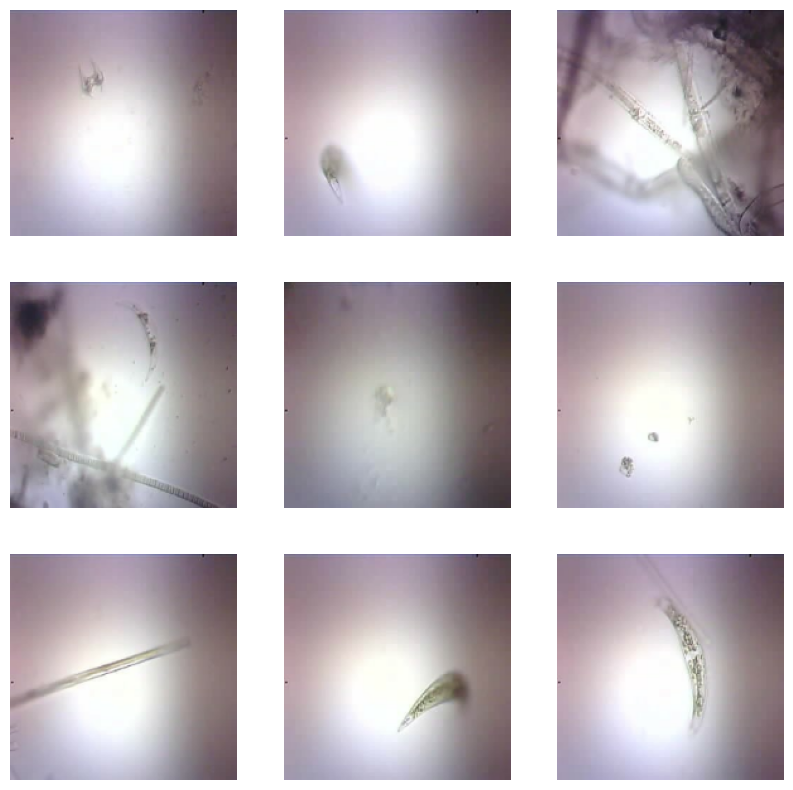

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")


In [36]:
# this stuff allows the use of buffered prefetching to load images from disk without i/o blocking

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling

model = Sequential()

model.add(Rescaling(1./255,  input_shape=(img_height, img_width, 3)))

# # these layers are from the tutorial
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

# 5 classes
model.add(Dense(5, activation='softmax'))

In [40]:
# SparseCategoricalCrossentropy when there are two or more label classes
model.compile(
            optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                

In [47]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
55/55 [==============================] - 16s 291ms/step - loss: 0.0793 - accuracy: 0.9761 - val_loss: 1.6328 - val_accuracy: 0.7574
Epoch 2/10
55/55 [==============================] - 15s 281ms/step - loss: 0.0584 - accuracy: 0.9875 - val_loss: 1.9417 - val_accuracy: 0.7551
Epoch 3/10
55/55 [==============================] - 15s 272ms/step - loss: 0.0450 - accuracy: 0.9869 - val_loss: 1.9458 - val_accuracy: 0.7755
Epoch 4/10
55/55 [==============================] - 16s 292ms/step - loss: 0.0386 - accuracy: 0.9869 - val_loss: 1.8932 - val_accuracy: 0.7528
Epoch 5/10
55/55 [==============================] - 15s 275ms/step - loss: 0.0466 - accuracy: 0.9835 - val_loss: 2.5138 - val_accuracy: 0.7574
Epoch 6/10
55/55 [==============================] - 15s 278ms/step - loss: 0.0358 - accuracy: 0.9920 - val_loss: 2.5321 - val_accuracy: 0.7619
Epoch 7/10
55/55 [==============================] - 15s 274ms/step - loss: 0.0329 - accuracy: 0.9909 - val_loss: 2.5523 - val_accuracy: 0.7506

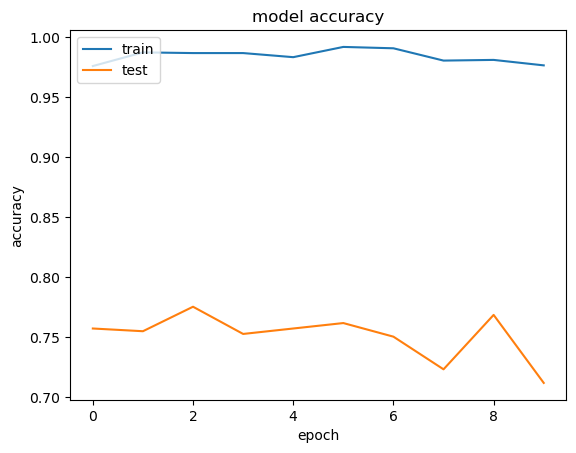

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

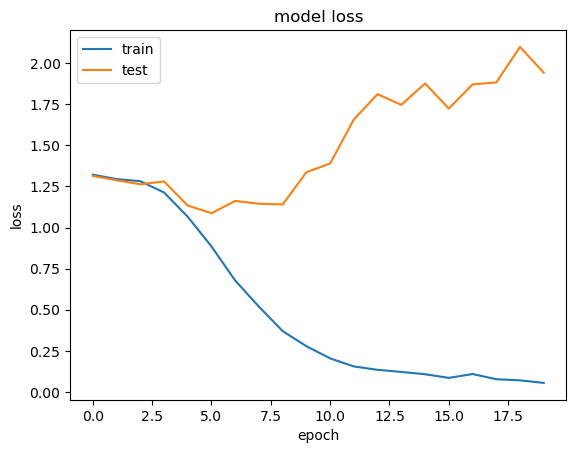

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# save the model to export
model.save("tf_model.h5")

# save the weights
model.save_weights("tf_model_weights.h5")

/Users/mateovelazquez/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
model = tf.keras.models.load_model("tf_model.h5")

In [46]:
tf.saved_model.save(model, "tf_model")
!python -m tf2onnx.convert --saved-model tf_model --output "tf_model.onnx"
!zip -r tf_model.zip tf_model

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


/Users/mateovelazquez/anaconda3/bin/python: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')
  adding: tf_model/ (stored 0%)
  adding: tf_model/fingerprint.pb (stored 0%)
  adding: tf_model/variables/ (stored 0%)
  adding: tf_model/variables/variables.data-00000-of-00001 (deflated 48%)
  adding: tf_model/variables/variables.index (deflated 66%)
  adding: tf_model/saved_model.pb (deflated 88%)
  adding: tf_model/assets/ (stored 0%)


Convert model into ESP-DL

In [ ]:
C